In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cloiud-dataset/clouds_train/high cumuliform clouds/991baa0d607f42df55ba08d4ffd1e0b8.jpg
/kaggle/input/cloiud-dataset/clouds_train/high cumuliform clouds/c503c78f26df6d653cda26e863b8464f.jpg
/kaggle/input/cloiud-dataset/clouds_train/high cumuliform clouds/fb368b6e71b6e228465adc23c4020019.jpg
/kaggle/input/cloiud-dataset/clouds_train/high cumuliform clouds/33246592ab22b3e817efc4b8a4acd540.jpg
/kaggle/input/cloiud-dataset/clouds_train/high cumuliform clouds/86222ad0fc2874de6d9747f9f0edcae2.jpg
/kaggle/input/cloiud-dataset/clouds_train/high cumuliform clouds/50ccb1d7734f13b823370ec7a902bdd1.jpg
/kaggle/input/cloiud-dataset/clouds_train/high cumuliform clouds/618b863e4f0ee634ba043f01a5e02558.jpg
/kaggle/input/cloiud-dataset/clouds_train/high cumuliform clouds/ee667b2bae418fb1402af98a93b3c992.jpg
/kaggle/input/cloiud-dataset/clouds_train/high cumuliform clouds/89798e8e342daae15f7930f5e48b6a1e.jpg
/kaggle/input/cloiud-dataset/clouds_train/high cumuliform clouds/e913f8b38587f6ae9

# **Table of Contents**
-----------------
✅ **Import Libraries.**   
✅ **Data Import & Transformation**   
✅ **Data Visualization.**   
✅ **Modeling & Prediction.**   
✅ **Evaluation.**   

# **Import Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from collections import Counter
import copy
import time
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Subset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.cuda import amp
from sklearn.model_selection import train_test_split , StratifiedKFold

In [3]:
# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **Data Import & Transformation**

In [4]:
Train_path = '/kaggle/input/cloiud-dataset/clouds_train'
Test_path = '/kaggle/input/cloiud-dataset/clouds_test'

In [5]:
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 4 
SEED = 42
N_FOLDS = 5
EPOCHS = 20
patience, bad = 5, 0

In [6]:
#Transform

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [7]:
base = datasets.ImageFolder(Train_path)
y = np.array(base.targets)

from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED)  
tr_idx, va_idx = next(sss.split(np.zeros(len(y)), y))

train_dataset = torch.utils.data.Subset(
    datasets.ImageFolder(Train_path, transform=train_tfms), tr_idx
)
val_dataset = torch.utils.data.Subset(
    datasets.ImageFolder(Train_path, transform=eval_tfms), va_idx
)
classes = base.classes

In [8]:
print("classes:", base.classes,'\n')
print("class_to_idx:", base.class_to_idx)

classes: ['cirriform clouds', 'clear sky', 'cumulonimbus clouds', 'cumulus clouds', 'high cumuliform clouds', 'stratiform clouds', 'stratocumulus clouds'] 

class_to_idx: {'cirriform clouds': 0, 'clear sky': 1, 'cumulonimbus clouds': 2, 'cumulus clouds': 3, 'high cumuliform clouds': 4, 'stratiform clouds': 5, 'stratocumulus clouds': 6}


In [9]:
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available()
)

val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available()
)


In [10]:
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])


# **Data Visualization**

In [11]:
dataset = train_dataset
classes = dataset.dataset.classes 

### **Class Distribution**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


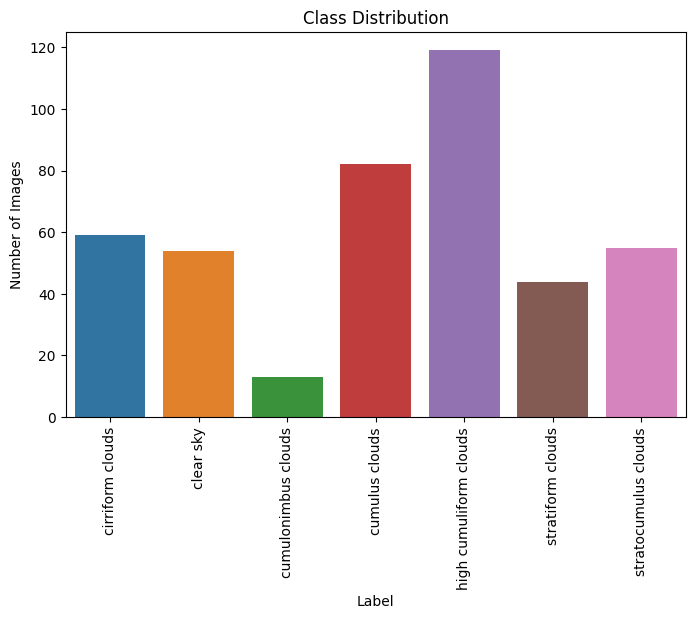

In [12]:
ds = dataset.dataset if hasattr(dataset, "dataset") else dataset

idxs = dataset.indices if hasattr(dataset, "indices") else range(len(dataset))

labels = [base.targets[i] for i in idxs]
label_counts = Counter(labels)
counts = [label_counts[i] for i in range(len(classes))]

plt.figure(figsize=(8,5))
sns.barplot(x=classes, y=counts)
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Number of Images")
plt.xticks(rotation=90)
plt.show()

### **Image Check**

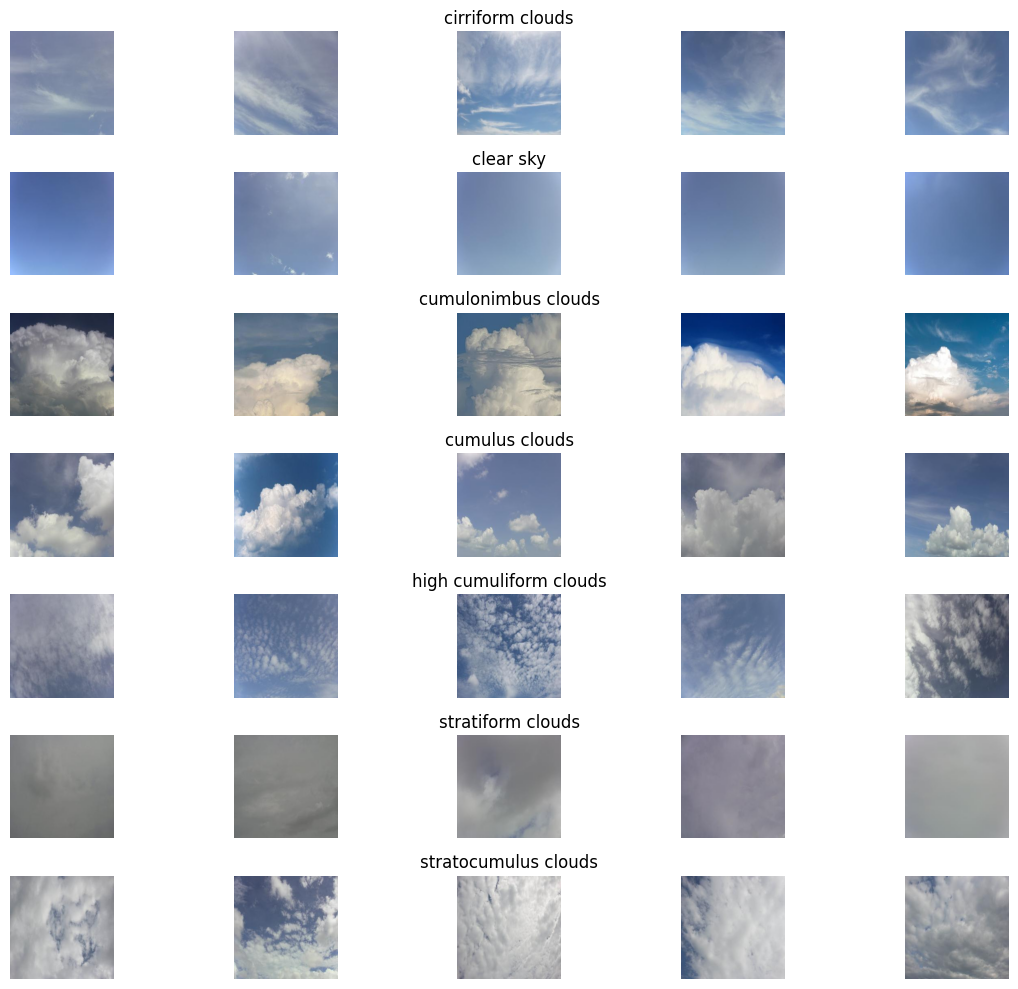

In [13]:
import random
import os
from PIL import Image

n_per_class = 5
plt.figure(figsize=(12, 10))

for idx, cls in enumerate(classes):
    cls_path = os.path.join(Train_path, cls)
    img_files = os.listdir(cls_path)
    samples = random.sample(img_files, n_per_class)
    
    for i, file in enumerate(samples):
        img_path = os.path.join(cls_path, file)
        img = Image.open(img_path).convert("RGB")
        
        plt.subplot(len(classes), n_per_class, idx*n_per_class + i + 1)
        plt.imshow(img)
        plt.axis("off")
        if i == 2:
            plt.title(cls)
plt.tight_layout()
plt.show()

### **PCA**

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s]


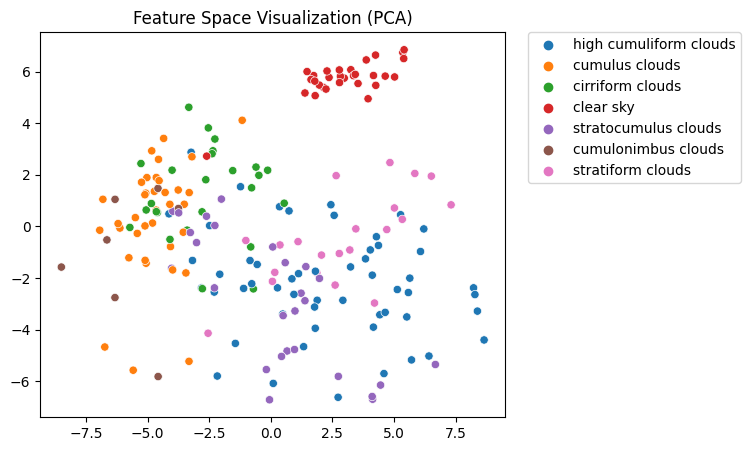

In [14]:
from torchvision.models import resnet18
from sklearn.decomposition import PCA
import torch

model = resnet18(weights='IMAGENET1K_V1')
model = torch.nn.Sequential(*(list(model.children())[:-1]))  
model.eval()

features, labels = [], []
for img, label in torch.utils.data.Subset(dataset, range(200)):
    x = transforms.Resize((224,224))(img).unsqueeze(0)
    with torch.no_grad():
        feat = model(x).squeeze().numpy()
    features.append(feat)
    labels.append(label)

pca = PCA(n_components=2)
proj = pca.fit_transform(features)

plt.figure(figsize=(6,5))
sns.scatterplot(x=proj[:,0], y=proj[:,1], hue=[classes[l] for l in labels])
plt.title("Feature Space Visualization (PCA)")
plt.legend(
    bbox_to_anchor=(1.05, 1),  
    loc='upper left',         
    borderaxespad=0.
)
plt.show()

# **Modeling(ResNet18)**

### **LOOP**

In [15]:
def accuracy(logits, y):
    return (logits.argmax(1) == y).float().mean().item()

def run_epoch(loader, model, train=True, scaler=None):
    model.train(train)
    total_loss, total_acc, n = 0.0, 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        if train:
            optimizer.zero_grad(set_to_none=True)
            with amp.autocast():
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            with torch.no_grad():
                logits = model(x)
                loss = criterion(logits, y)

        bs = y.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy(logits, y) * bs
        n += bs

    return total_loss / n, total_acc / n


## **K-FOLDS**

In [16]:
# Base
base = datasets.ImageFolder(Train_path)  
classes = base.classes
y = np.array(base.targets)

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
fold_results = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(np.zeros(len(y)), y), start=1):
    print(f"\n===== Fold {fold}/{N_FOLDS} =====")

    # Datasets / Loaders
    train_set = Subset(datasets.ImageFolder(Train_path, transform=train_tfms), tr_idx)
    val_set   = Subset(datasets.ImageFolder(Train_path, transform=eval_tfms),  va_idx)

    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available())
    val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available())

    # Model / Opt / Sched
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, len(classes))
    
    for name, p in model.named_parameters():
        p.requires_grad = name.startswith("fc.")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                            lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    scaler = amp.GradScaler()

    history = {'Train_Loss': [], 'Validation_Loss': [],
               'Train_Accuracy': [], 'Validation_Accuracy': []}

    best_wts = copy.deepcopy(model.state_dict())
    best_val = -1.0
    bad = 0

    # ---- Epoch loop ----
    for epoch in range(1, EPOCHS+1):
        t0 = time.time()
        train_loss, train_acc = run_epoch(train_loader, model, train=True,  scaler=scaler)
        val_loss,   val_acc   = run_epoch(val_loader,   model, train=False, scaler=None)

        scheduler.step()
        elapsed = time.time() - t0

        print(f"[Fold {fold}][{epoch:02d}] "
              f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f} acc={val_acc:.4f} | time={elapsed:.1f}s")

        history['Train_Loss'].append(train_loss)
        history['Validation_Loss'].append(val_loss)
        history['Train_Accuracy'].append(train_acc)
        history['Validation_Accuracy'].append(val_acc)

        # Early stopping
        if val_acc > best_val:
            best_val = val_acc
            best_wts = copy.deepcopy(model.state_dict())
            bad = 0
            torch.save(best_wts, f"best_fold{fold}.pt")
        else:
            bad += 1
            if bad >= patience:
                print(f"Early stopping (fold {fold})")
                break

    
    model.load_state_dict(best_wts)
    fold_results.append(best_val)


print("\nK-Fold Val Acc mean:", np.mean(fold_results), "std:", np.std(fold_results))


===== Fold 1/5 =====


/tmp/ipykernel_37/691205290.py:33: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
/tmp/ipykernel_37/1439564820.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


[Fold 1][01] train_loss=1.7302 acc=0.3219 | val_loss=1.4807 acc=0.5789 | time=4.3s
[Fold 1][02] train_loss=1.2702 acc=0.6675 | val_loss=1.1312 acc=0.7263 | time=1.4s
[Fold 1][03] train_loss=1.0004 acc=0.7599 | val_loss=0.9382 acc=0.8000 | time=1.4s
[Fold 1][04] train_loss=0.8450 acc=0.8153 | val_loss=0.8268 acc=0.8526 | time=1.4s
[Fold 1][05] train_loss=0.7700 acc=0.8443 | val_loss=0.7673 acc=0.8632 | time=1.4s
[Fold 1][06] train_loss=0.6844 acc=0.8892 | val_loss=0.7339 acc=0.8737 | time=1.4s
[Fold 1][07] train_loss=0.6643 acc=0.8997 | val_loss=0.7182 acc=0.8632 | time=1.3s
[Fold 1][08] train_loss=0.6556 acc=0.9129 | val_loss=0.7065 acc=0.8632 | time=1.4s
[Fold 1][09] train_loss=0.6506 acc=0.9182 | val_loss=0.6992 acc=0.8737 | time=1.3s
[Fold 1][10] train_loss=0.6497 acc=0.9024 | val_loss=0.6979 acc=0.8842 | time=1.4s
[Fold 1][11] train_loss=0.6488 acc=0.9129 | val_loss=0.6968 acc=0.8842 | time=1.4s
[Fold 1][12] train_loss=0.6443 acc=0.8839 | val_loss=0.6956 acc=0.8737 | time=1.4s
[Fol

**The K-Fold cross-validation results show that the model performs consistently across different data splits.**   
A high mean validation accuracy (≈0.89) with a small standard deviation (≈0.02) indicates that the model’s performance does not heavily depend on a particular subset of the training data.
This means the model has learned generalizable patterns rather than memorizing specific samples, demonstrating **stable and well-generalized performance**.

## **Training**

In [17]:
base = datasets.ImageFolder(Train_path)
y = np.array(base.targets)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED)  # val 10%
tr_idx, va_idx = next(sss.split(np.zeros(len(y)), y))

train_dataset = torch.utils.data.Subset(
    datasets.ImageFolder(Train_path, transform=train_tfms), tr_idx
)
val_dataset = torch.utils.data.Subset(
    datasets.ImageFolder(Train_path, transform=eval_tfms), va_idx
)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available())
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available())

In [19]:
test_dataset = datasets.ImageFolder(Test_path, transform=eval_tfms)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available())

In [20]:
classes = base.classes

In [21]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, len(classes))

for name, p in model.named_parameters():
    p.requires_grad = name.startswith("fc.") 
model = model.to(device)

### **Optimizer**

In [22]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [23]:
scaler = amp.GradScaler()
best_wts = copy.deepcopy(model.state_dict())
best_val = -np.inf

/tmp/ipykernel_37/3046083102.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


In [24]:
history = {'Train_Loss': [], 'Validation_Loss': [],
           'Train_Accuracy': [], 'Validation_Accuracy': []}

for epoch in tqdm(range(1, EPOCHS+1)):
    t0 = time.time()
    train_loss, train_acc = run_epoch(train_loader, model, train=True, scaler=scaler)
    val_loss,   val_acc   = run_epoch(val_loader,   model, train=False)

    scheduler.step()
    elapsed = time.time()-t0

    print(f"[{epoch:02d}] "
          f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.4f} | "
          f"time={elapsed:.1f}s")

    history['Train_Loss'].append(train_loss)
    history['Validation_Loss'].append(val_loss)
    history['Train_Accuracy'].append(train_acc)
    history['Validation_Accuracy'].append(val_acc)

    # early stopping
    if val_acc > best_val:
        best_val = val_acc
        best_wts = copy.deepcopy(model.state_dict())
        bad = 0
        torch.save(best_wts, "best.pt")
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping triggered.")
            break

# 베스트 가중치 로드
model.load_state_dict(best_wts)

  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_37/1439564820.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


[01] train_loss=1.6540 acc=0.4014 | val_loss=1.3939 acc=0.5833 | time=1.7s
[02] train_loss=1.1989 acc=0.6808 | val_loss=1.0191 acc=0.7083 | time=1.5s
[03] train_loss=0.9366 acc=0.7911 | val_loss=0.8246 acc=0.8958 | time=1.5s
[04] train_loss=0.8142 acc=0.8380 | val_loss=0.7314 acc=0.8542 | time=1.5s
[05] train_loss=0.7732 acc=0.8451 | val_loss=0.6794 acc=0.8542 | time=1.5s
[06] train_loss=0.7000 acc=0.8779 | val_loss=0.6458 acc=0.9167 | time=1.4s
[07] train_loss=0.6579 acc=0.8944 | val_loss=0.6381 acc=0.8542 | time=1.5s
[08] train_loss=0.6628 acc=0.8897 | val_loss=0.6299 acc=0.8958 | time=1.5s
[09] train_loss=0.6537 acc=0.8850 | val_loss=0.6204 acc=0.8958 | time=1.5s
[10] train_loss=0.6358 acc=0.8897 | val_loss=0.6250 acc=0.8750 | time=1.4s
[11] train_loss=0.6270 acc=0.9038 | val_loss=0.6198 acc=0.8750 | time=1.4s
Early stopping triggered.


<All keys matched successfully>

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

model.eval()
all_y, all_p = [], []
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        logits = model(x)
        all_p += logits.argmax(1).cpu().tolist()
        all_y += y.tolist()

cm = confusion_matrix(all_y, all_p)
print(classification_report(all_y, all_p, target_names=base.classes))
print(cm)


                        precision    recall  f1-score   support

      cirriform clouds       0.86      0.86      0.86         7
             clear sky       1.00      1.00      1.00         6
   cumulonimbus clouds       1.00      1.00      1.00         1
        cumulus clouds       0.80      0.89      0.84         9
high cumuliform clouds       0.93      1.00      0.97        14
     stratiform clouds       1.00      1.00      1.00         5
  stratocumulus clouds       1.00      0.67      0.80         6

              accuracy                           0.92        48
             macro avg       0.94      0.92      0.92        48
          weighted avg       0.92      0.92      0.91        48

[[ 6  0  0  1  0  0  0]
 [ 0  6  0  0  0  0  0]
 [ 0  0  1  0  0  0  0]
 [ 1  0  0  8  0  0  0]
 [ 0  0  0  0 14  0  0]
 [ 0  0  0  0  0  5  0]
 [ 0  0  0  1  1  0  4]]


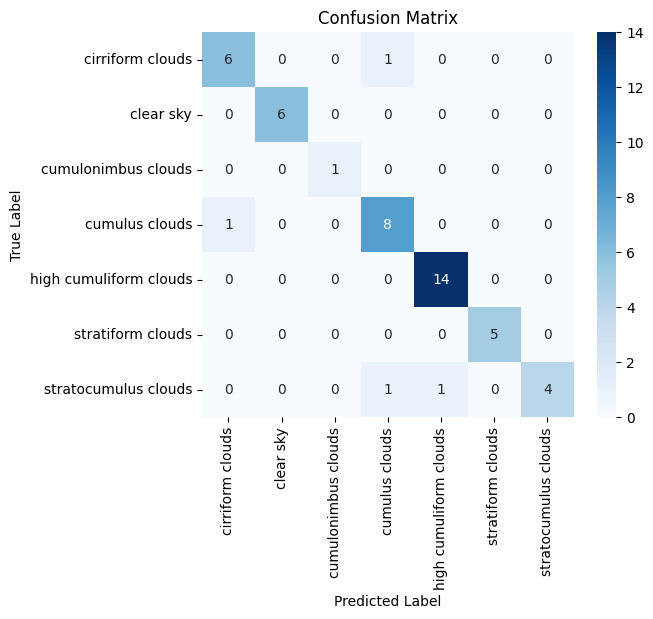

In [26]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## **Evaluation**

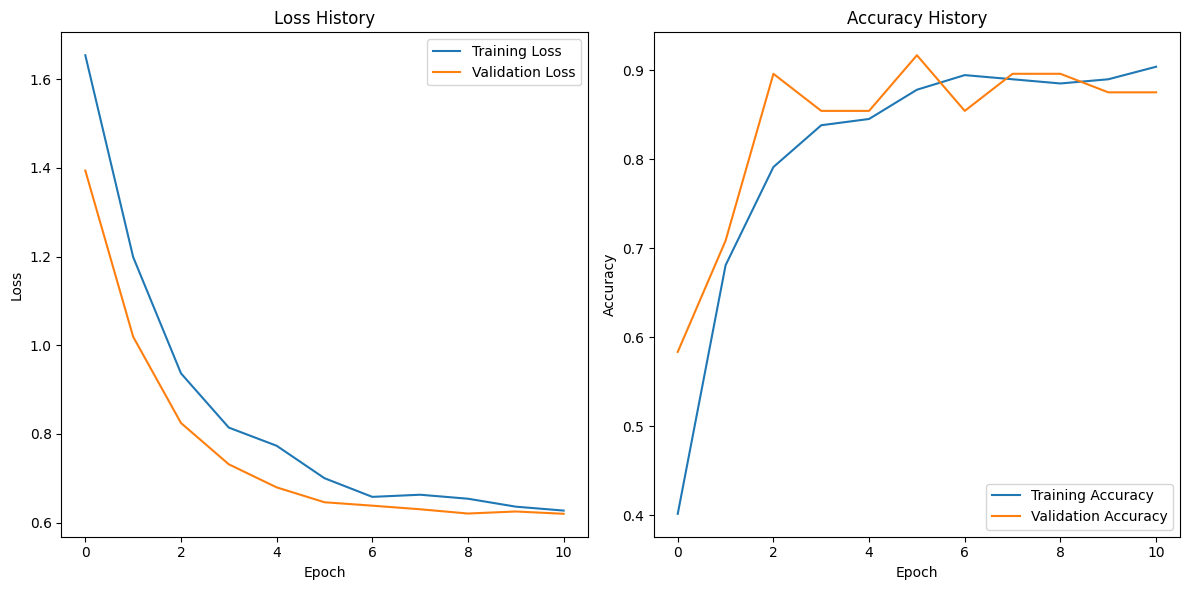

In [27]:
# Visualize training history

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['Train_Loss'], label='Training Loss')
plt.plot(history['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(history['Train_Accuracy'], label='Training Accuracy')
plt.plot(history['Validation_Accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.tight_layout()
plt.show()

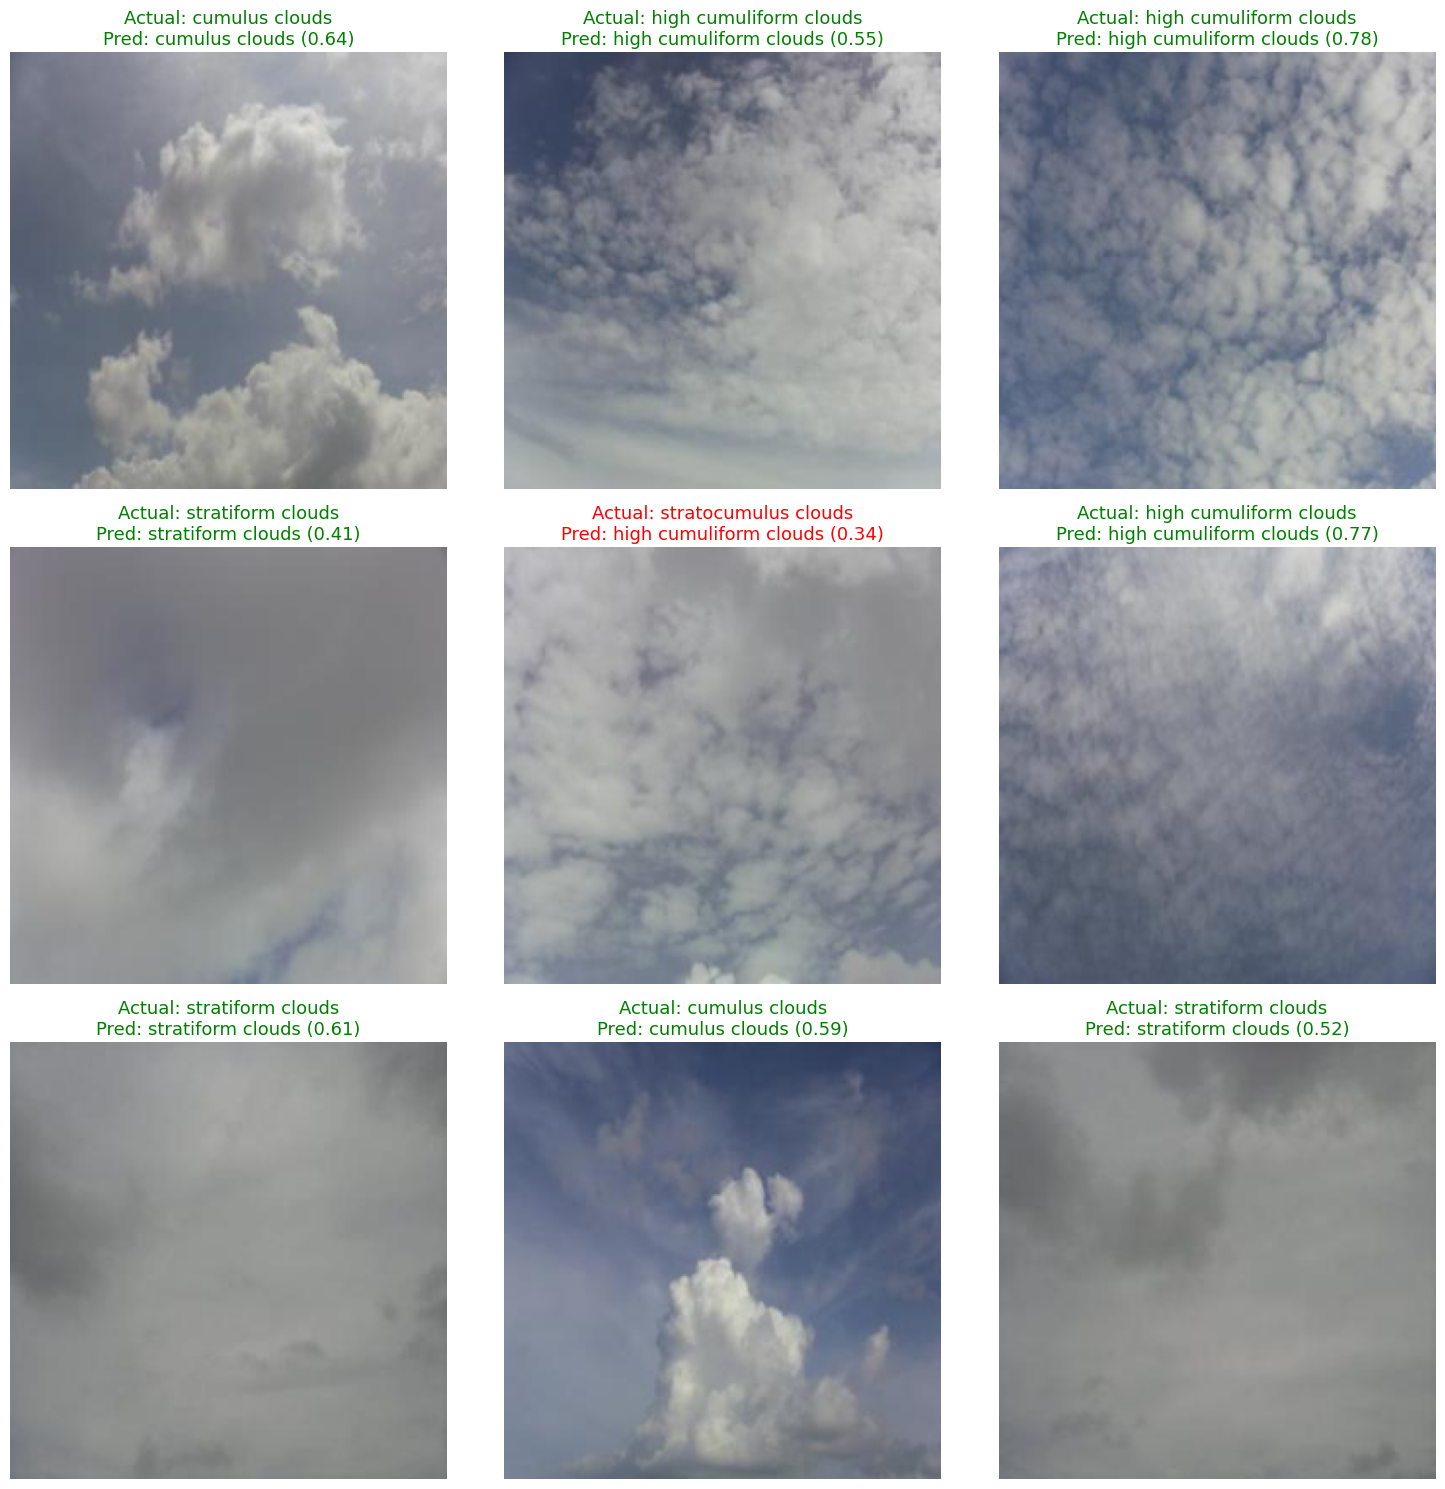

In [28]:
# Release Normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def denormalize(img_tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    img = img_tensor.detach().cpu().clone()
    for c, (m, s) in enumerate(zip(mean, std)):
        img[c] = img[c] * s + m
    img = img.clamp(0, 1)
    return img.permute(1, 2, 0).numpy()

images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

model.eval()
with torch.no_grad():
    logits = model(images)
    preds = logits.argmax(1)
    probs = F.softmax(logits, dim=1)
    confidences = probs.max(1).values

plt.figure(figsize=(15, 15))
class_names = base.classes  # ImageFolder 기준

for i in range(9): 
    ax = plt.subplot(3, 3, i + 1)
    img = denormalize(images[i])
    plt.imshow(img)
    plt.axis("off")

    actual_class = class_names[labels[i].item()]
    predicted_class = class_names[preds[i].item()]
    conf = confidences[i].item()

    label_color = "green" if actual_class == predicted_class else "red"
    plt.title(f"Actual: {actual_class}\nPred: {predicted_class} ({conf:.2f})",
              color=label_color, fontsize=13)

plt.tight_layout()
plt.show()

In [29]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return running_loss/len(data_loader), accuracy

### **Accuracy**

In [30]:
test_loss, test_acc = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}%")

Test Loss: 0.7091816961765289, Test Accuracy: 87.86008230452676%


### **F1_Score**

In [31]:
from sklearn.metrics import f1_score

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

f1 = f1_score(y_true, y_pred, average='weighted') 
print(f"F1-score: {f1:.4f}")

F1-score: 0.8745


---------------
### **Thankyou. Please leave your advice in the comments.**